compare spending rules

Summary: 

Read in returns data, risk free rate and inflation rate<br>

Create 3 portfolios, 1 of stocks, 60/40 (stocks/bonds) and 60/40/40 (stocks/bonds/managed futures)

look at the impact of different spending policies across different measures:<br>
    measure amount paid out <br>
    consistancy of payments <br>
    final wealth of portfolio<br>

To Do In Future:

Currently using stock and bond returns for US. In next iteration expand analysis by randomly pulling returns from different countries on each year since US stock returns are abnormal.

FRED Inflation statistics are revised. in next iteration use ALFRED point in time correct estimates to see how much this impacts analysis. Is suspect effect is small

# Reading: 

Princeton spending rule: http://pr.princeton.edu/news/01/q1/0127-endowspend.htm#:~:text=While%20Princeton's%20policy%20does%20not,endowment%20was%20desirable%20and%20appropriate.

Harvard spending rule: https://www.harvardmagazine.com/2016/10/how-harvard-sets-endowment-distribution <br>

Yale spending rule: https://your.yale.edu/policies-procedures/policies/2202-endowment-spending-and-distributions#:~:text=The%20spending%20amount%20determined%20by,start%20of%20the%20prior%20year.


investment alts
https://pictureperfectportfolios.com/10-ways-investors-can-improve-a-60-40-portfolio-ultimate-enhanced-60-40-portfolio-etfs/

#article on trend followin
https://www.aima.org/article/trend-following-what-s-not-to-like.html

#managed futres explainer
#http://advisor.morningstar.com/uploaded/pdf/Alt_Managed-Category.pdf

In [1]:
fred_api_key = '3c93f8c94cd55ed22584015fb3d29aff'

In [6]:
from educational_resources.Datasets.data_preprocessing import shiller_data, BTOP50_data
import pandas as pd
import numpy as np

from fredapi import Fred
fred = Fred(api_key=fred_api_key)

inflation='CPIAUCSL'
risk_free_rate = 'FEDFUNDS'

inflation_series = fred.get_series(inflation).pct_change()
#inflation_series_first_release = fred.get_series_first_release(inflation)

risk_free_rate_series = fred.get_series(risk_free_rate)/(12*100)
#risk_free_rate_series_first_release = fred.get_series_first_release(risk_free_rate)

FRED_data = pd.concat([inflation_series,risk_free_rate_series],axis=1).rename(columns={0:'inflation_index',1:'risk_free_rate'})

stock_series = fred.get_series('SP500')
temp = stock_series.resample('m').first().reset_index()
temp['index'] = pd.to_datetime(temp['index'].astype('str').str[:-3], format='%Y-%m')
stock_series = temp.set_index('index')[0]
stock_series = stock_series.pct_change()

#data is inflation adjusted. I correct for this later on
stocknbonddata = shiller_data()
stocknbonddata.columns = ['Stock','Long Bonds']
stocknbonddata['Stock'] = stocknbonddata['Stock'].str.replace(',', '').astype(float)

MonRtns = stocknbonddata.pct_change().dropna().reset_index()

CTA = BTOP50_data()

returns = CTA.merge(MonRtns, on='Date')[1:]
returns['CTA'] = returns['CTA'].astype(float)
returns = returns.set_index('Date')

all_data = pd.concat([returns,FRED_data],axis=1)

#uninflation adjust bonds and stocks index 
all_data['Stock'] = all_data['Stock'] + all_data['inflation_index']
all_data['Long Bonds'] = all_data['Long Bonds'] + all_data['inflation_index']

all_data['60/40'] = .6 * all_data['Stock'] + .4 * all_data['Long Bonds']
all_data['60/40/40'] = (.6 * all_data['Stock'] + .4 * all_data['Long Bonds'] + 
                        .4 * all_data['CTA'] - (.4 * all_data['risk_free_rate']+.005/12)) #60/40/40 - 40 (risk free + 50 bp annually)


overlapping_period_data = all_data.dropna().copy(deep=True)

/var/folders/7t/xs9w6h6s6pdf6vfnsqt9r3p80000gn/T/ipykernel_17765/1158121281.py:20: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  temp = stock_series.resample('m').first().reset_index()


In [7]:
def plot_cumrtn(data):
    ((data+1).cumprod()-1).plot()
    
portfolios =['Stock','60/40','60/40/40'] 
#plot_cumrtn(overlapping_period_data[portfolios])


def apply_rule(rule, prior_year_nominal_payout, previous_year_starting_balance, current_balance, trailing_1_yr_adj):
    if current_balance == 0:
        return 0 
    if rule == 'yale_rule':
        to_spend = yale_rule(prior_year_nominal_payout, 
                              previous_year_starting_balance, 
                              trailing_1_yr_adj)
    
    elif rule == 'four_pct_infl_adj':
        to_spend = four_percent_rule(prior_year_nominal_payout, trailing_1_yr_adj)
    
    if to_spend <= current_balance:
        return to_spend
    else:
        return current_balance
    
def four_percent_rule(prior_year_nominal_payout, trailing_1_yr_adj):
    '''
    trailing 1 year adjustment is the adjustment due to inflation and taxes
    '''
    return prior_year_nominal_payout * (1+trailing_1_yr_adj)

def yale_rule(prior_year_nominal_payout, previous_year_starting_balance, trailing_1_yr_adj, smoothing = .2):
    '''
    5.25% is yales target long term payout yale has fixed constraints so the payout is not 
    more than 6.5% of the market value and not less than 4% after adjusting for inflation and taxes
    
    trailing 1 year adjustment is the adjustment due to inflation and taxes
    '''
    combined_rate = smoothing * .0525 * previous_year_starting_balance + (1-smoothing) * prior_year_nominal_payout
    minimum = .04*previous_year_starting_balance
    maximum = .065*previous_year_starting_balance
    return min(max(minimum, combined_rate*(1+trailing_1_yr_adj)), maximum)

# def harvard_rule(prior_year_nominal_payout, previous_year_starting_balance, trailing_1_yr_adj, smoothing=.3):
#     previous_spending = prior_year_nominal_payout * trailing_1_yr_adj * (1-smoothing)
#     smoothing_comp = (previous_year_starting_balance - prior_year_nominal_payout)* 1.072 * .0525 * smoothing
#     combined = previous_spending + smoothing_comp
#     return combined

# create annual data for analysis , dont forget to come backand redo analysis with distribution in different months

In [8]:
spending_calc_data = overlapping_period_data.copy(deep=True).drop(columns=['CTA','Long Bonds','risk_free_rate'])

annualized_returns = {}
#spending_calc_data
relevant_cols = ['Stock','inflation_index','60/40','60/40/40']
for i in np.arange(12):
    temp_data = spending_calc_data[relevant_cols].copy(deep=True)
    temp_data.index = temp_data.index+pd.DateOffset(months=i)
    annualized_returns['offset'+str(i)] = temp_data.resample('A').apply(lambda x: ((x + 1).cumprod()-1).last("D"))

/var/folders/7t/xs9w6h6s6pdf6vfnsqt9r3p80000gn/T/ipykernel_17765/2676827377.py:9: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  annualized_returns['offset'+str(i)] = temp_data.resample('A').apply(lambda x: ((x + 1).cumprod()-1).last("D"))
/var/folders/7t/xs9w6h6s6pdf6vfnsqt9r3p80000gn/T/ipykernel_17765/2676827377.py:9: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  annualized_returns['offset'+str(i)] = temp_data.resample('A').apply(lambda x: ((x + 1).cumprod()-1).last("D"))
/var/folders/7t/xs9w6h6s6pdf6vfnsqt9r3p80000gn/T/ipykernel_17765/2676827377.py:9: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  annualized_returns['offset'+str(i)] = temp_data.resample('A').apply(lambda x: ((x + 1).cumprod()-1).last("D"))
/var/folders/7t/xs9w6h6s6pdf6vfnsqt9r3p80000gn/T/ipykernel_17765/2676827377.py:9: FutureW

In [9]:
analytics = {}

rules = ['four_pct_infl_adj','yale_rule'] #'harvard_rule'
portfolios = ['Stock','60/40','60/40/40']

starting_value = 10**6
starting_spend = {'four_pct_infl_adj':starting_value * .04,
                  'yale_rule':starting_value * .0525}
                  #'harvard_rule': starting_value * 

for rule in rules:
    analytics[rule] = {}
    for portfolio in portfolios:
        analytics[rule][portfolio] = {}
        for data in ['market_value','spending']:
            analytics[rule][portfolio][data] = []


#simulation assumes we start with a lump sum of money and immediately withdraw 
#from it at the start of the simulation and each year afterword at the start of the year

#using offset0 annualized returns to start
market_data = annualized_returns['offset0'].iloc[13:] #starting in 2000 as a worst case scenario
for index, row in market_data.iterrows():
    if index < market_data.index[1]:
        for rule in rules[:1]: # testing
            for portfolio in portfolios: # testing
                #starting account value
                analytics[rule][portfolio]['market_value'].append(starting_value)
                
                #first year spend
                analytics[rule][portfolio]['spending'].append(starting_spend[rule])
                
                #update account value based on dollar invested and investment returns
                invested_dollars = starting_value - starting_spend[rule]
                market_value_end_of_year = invested_dollars * (row[portfolio]+1)
                analytics[rule][portfolio]['market_value'].append(market_value_end_of_year)
                    
    if index >= market_data.index[1]:
        prev_year_spending = analytics[rule][portfolio]['spending'][-1]
        prev_start_of_year_mv = analytics[rule][portfolio]['market_value'][-2]
        current_mv = analytics[rule][portfolio]['market_value'][-1]
        for rule in rules[:1]: # testing
            for portfolio in portfolios: # testing
                spending = apply_rule(rule, 
                                      prev_year_spending,
                                      prev_start_of_year_mv,
                                      current_mv,
                                      row['inflation_index'])
                
                analytics[rule][portfolio]['spending'].append(spending)
                
                invested_dollars = current_mv - analytics[rule][portfolio]['spending'][-1]
                market_value_end_of_year = invested_dollars * (row[portfolio]+1)
                analytics[rule][portfolio]['market_value'].append(market_value_end_of_year)
#                 print('index',index)
#                 print('current_mv', current_mv)
#                 print('spending', spending)
#                 print('invested_dollar', invested_dollars)
#                 print()
        
        #once I get this working just need to apply 4%, yale and harvard functions to data on that row
    
    
for rule in rules:
    for portfolio in portfolios:
        for data in ['market_value','spending']:
            analytics[rule][portfolio][data] = pd.Series(analytics[rule][portfolio][data])
        analytics[rule][portfolio] = pd.DataFrame.from_dict(analytics[rule][portfolio], orient='index').T

sim_rule_stats = {}
for rule in rules:
    sim_rule_stats[rule] = pd.concat(analytics[rule],axis=1)
sim_rule_stats = pd.concat(sim_rule_stats, axis=1)

In [10]:
market_data.head()

,Stock,inflation_index,60/40,60/40/40
2000-12-31,-0.056908,0.034360,0.021943,0.020494
2001-12-31,-0.127599,0.016037,-0.049902,-0.051600
2002-12-31,-0.200665,0.024803,-0.073142,-0.032228
2003-12-31,0.224943,0.020352,0.141298,0.199637
2004-12-31,0.128665,0.033423,0.096812,0.088934


In [11]:
sim_rule_stats

four_pct_infl_adj                                                          \
               Stock                       60/40                    60/40/40   
        market_value      spending  market_value      spending  market_value   
0       1.000000e+06  40000.000000  1.000000e+06  40000.000000  1.000000e+06   
1       9.053680e+05  40641.466208  9.810656e+05  40641.466208  9.796745e+05   
2       8.192132e+05  41649.484536  8.921735e+05  41649.484536  8.905785e+05   
3       6.785783e+05  42497.136312  7.868362e+05  42497.136312  8.215695e+05   
4       9.543193e+05  43917.525773  8.891539e+05  43917.525773  9.346037e+05   
5       1.005286e+06  45383.734250  9.769150e+05  45383.734250  9.698986e+05   
6       9.896643e+05  46529.209622  9.723993e+05  46529.209622  9.652871e+05   
7       1.049459e+06  48441.008018  1.011763e+06  48441.008018  1.008729e+06   
8       1.021349e+06  48430.240550  1.032399e+06  48430.240550  1.036585e+06   
9       5.998157e+05  49793.127148  7.961201e+05  49793.127148  8.294690e+05   
10      1.014188e+06  50509.049255  8.929195e+05  50509.049255  8.708254e+05   
11      9.343659e+05  52055.670103  9.103322e+05  52055.670103  9.278549e+05   
12      8.951926e+05  52971.592211  9.441605e+05  52971.592211  9.231544e+05   
13      1.015924e+06  53772.966781  9.727393e+05  53772.966781  9.607652e+05   
14      1.176383e+06  54124.169530  1.027681e+06  54124.169530  1.025031e+06   
15      1.123880e+06  54469.873998  1.097803e+06  54469.873998  1.143540e+06   
16      1.110356e+06  55586.941581  1.110939e+06  55586.941581  1.101217e+06   
17      1.167782e+06  56770.904926  1.117921e+06  56770.904926  1.091236e+06   
18      1.250679e+06  57907.674685  1.174459e+06  57907.674685  1.160781e+06   
19      1.083897e+06  59250.859107  1.089889e+06  59250.859107  1.056913e+06   
20      1.258191e+06  60024.054983  1.198376e+06  60024.054983  1.213646e+06   
21      1.364292e+06  64331.729668  1.339635e+06  64331.729668  1.356057e+06   
22      1.657985e+06  68456.357388  1.481811e+06  68456.357388  1.531342e+06   
23      1.408466e+06  70731.271478  1.345484e+06  70731.271478  1.411412e+06   
24      1.630291e+06  72268.957617  1.512499e+06  72268.957617  1.465102e+06   
25      1.727258e+06           NaN  1.600123e+06           NaN  1.574164e+06   

                  
                  
        spending  
0   40000.000000  
1   40641.466208  
2   41649.484536  
3   42497.136312  
4   43917.525773  
5   45383.734250  
6   46529.209622  
7   48441.008018  
8   48430.240550  
9   49793.127148  
10  50509.049255  
11  52055.670103  
12  52971.592211  
13  53772.966781  
14  54124.169530  
15  54469.873998  
16  55586.941581  
17  56770.904926  
18  57907.674685  
19  59250.859107  
20  60024.054983  
21  64331.729668  
22  68456.357388  
23  70731.271478  
24  72268.957617  
25           NaN

<AxesSubplot:>

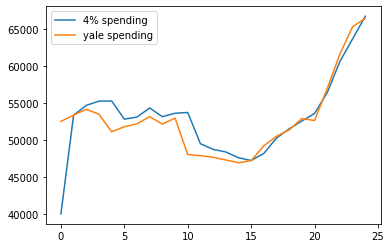

In [41]:
pd.concat([sim_rule_stats['four_pct_infl_adj']['Stock']['spending'].rename('4% spending'),
           sim_rule_stats['yale_rule']['Stock']['spending'].rename('yale spending')], axis=1).plot()

In [34]:
sim_rule_stats

four_pct_infl_adj                                                          \
               Stock                       60/40                    60/40/40   
        market_value      spending  market_value      spending  market_value   
0       1.000000e+06  40000.000000  1.000000e+06  40000.000000  1.000000e+06   
1       9.053680e+05  53341.924399  9.810656e+05  53341.924399  9.796745e+05   
2       7.970049e+05  54664.948454  8.679872e+05  54664.948454  8.664354e+05   
3       6.488762e+05  55238.200129  7.523956e+05  55238.200129  7.856085e+05   
4       8.952886e+05  55260.533328  8.341542e+05  55260.533328  8.767926e+05   
5       9.296240e+05  52803.727480  9.033882e+05  52803.727480  8.968999e+05   
6       9.084309e+05  53086.542009  8.925830e+05  53086.542009  8.860547e+05   
7       9.526867e+05  54316.871897  9.184665e+05  54316.871897  9.157122e+05   
8       9.172342e+05  53139.212216  9.271582e+05  53139.212216  9.309175e+05   
9       5.335804e+05  53601.873395  7.082077e+05  53601.873395  7.378740e+05   
10      8.911857e+05  53706.025287  7.846245e+05  53706.025287  7.652100e+05   
11      8.112612e+05  49486.917196  7.903939e+05  49486.917196  8.056079e+05   
12      7.794421e+05  48720.628495  8.220783e+05  48720.628495  8.037884e+05   
13      8.835086e+05  48373.892386  8.459527e+05  48373.892386  8.355393e+05   
14      1.022495e+06  47593.472171  8.932454e+05  47593.472171  8.909420e+05   
15      9.776487e+05  47217.373347  9.549646e+05  47217.373347  9.947507e+05   
16      9.668639e+05  48169.558198  9.673723e+05  48169.558198  9.589064e+05   
17      1.017148e+06  50251.256813  9.737192e+05  50251.256813  9.504761e+05   
18      1.087076e+06  51495.031285  1.020827e+06  51495.031285  1.008938e+06   
19      9.407123e+05  52555.716679  9.459133e+05  52555.716679  9.172930e+05   
20      1.090712e+06  53571.422306  1.038859e+06  53571.422306  1.052096e+06   
21      1.180404e+06  56391.745469  1.159070e+06  56391.745469  1.173279e+06   
22      1.435014e+06  60600.016260  1.282533e+06  60600.016260  1.325403e+06   
23      1.217116e+06  63648.981723  1.162691e+06  63648.981723  1.219662e+06   
24      1.404556e+06  66710.646679  1.303074e+06  66710.646679  1.262239e+06   
25      1.480355e+06           NaN  1.371394e+06           NaN  1.349145e+06   

                     yale_rule                                            \
                         Stock                       60/40                 
        spending  market_value      spending  market_value      spending   
0   40000.000000  1.000000e+06  52500.000000  1.000000e+06  52500.000000   
1   53341.924399  8.935794e+05  53341.924399  9.682913e+05  53341.924399   
2   54664.948454  7.970049e+05  54136.413927  8.679872e+05  54136.413927   
3   55238.200129  6.492986e+05  53473.286032  7.528854e+05  53473.286032   
4   55260.533328  8.974505e+05  51097.801908  8.361685e+05  51097.801908   
5   52803.727480  9.343224e+05  51779.635510  9.079539e+05  51779.635510   
6   53086.542009  9.095272e+05  52173.173555  8.936602e+05  52173.173555   
7   54316.871897  9.537300e+05  53151.026627  9.194723e+05  53151.026627   
8   53139.212216  9.184741e+05  52134.737687  9.284116e+05  52134.737687   
9   53601.873395  5.341901e+05  52944.788808  7.090169e+05  52944.788808   
10  53706.025287  8.920404e+05  48016.616311  7.853770e+05  48016.616311   
11  49486.917196  8.177416e+05  47878.209023  7.967077e+05  47878.209023   
12  48720.628495  7.810864e+05  47652.979825  8.238126e+05  47652.979825   
13  48373.892386  8.847551e+05  47284.646032  8.471462e+05  47284.646032   
14  47593.472171  1.023908e+06  46917.698394  8.944796e+05  46917.698394   
15  47217.373347  9.784310e+05  47201.549338  9.557287e+05  47201.549338   
16  48169.558198  9.668801e+05  49203.261433  9.673884e+05  49203.261433   
17  50251.256813  1.015993e+06  50484.146379  9.726140e+05  50484.146379   
18  51495.031285  1.086795e+06  51364.307458  1.020563e+06  51364.307458   
19  52555.

In [ ]:
#some capital market assumptions if useful in the future

# long term return asusmptions
# 8% market returns
# 5% bond and CTA returns
# 4.5% risk free
# 3% inflation returns

# print('portfolio return assumptions', round(.6*.08+.4*.05+.4*.05-.4*.04,3))
# print('inflation assumption', .03)

# FRED_data.loc[:'1986-01-01'].resample("A").apply(lambda x: ((x + 1).cumprod()-1).last("D")).mean()